# Align2D — Simple Demo

Align two HAADF-STEM images of a perovskite crystal acquired at 0° and 90° specimen rotation.

In [ ]:
# Install in Google Colab
try:
    import google.colab
    !pip install -q -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ quantem-widget
except ImportError:
    pass  # Not in Colab, skip

In [ ]:
try:
    %load_ext autoreload
    %autoreload 2
    %env ANYWIDGET_HMR=1
except Exception:
    pass  # autoreload unavailable (Colab Python 3.12+)

In [2]:
import numpy as np
from scipy.ndimage import shift as ndi_shift
from quantem.widget import Align2D, Show2D

rng = np.random.default_rng(42)
N = 512

# Perovskite crystal (SrTiO3-like [001] HAADF-STEM simulation)
y, x = np.mgrid[:N, :N]
img = np.zeros((N, N), dtype=np.float32)
a = 16       # lattice parameter (px)
sig_a = 2.2  # A-site column width (Sr, heavy)
sig_b = 1.8  # B-site column width (Ti, lighter)

# A-site columns (bright) at lattice corners
for i in range(-1, N // a + 2):
    for j in range(-1, N // a + 2):
        cx, cy = i * a, j * a
        if -a < cx < N + a and -a < cy < N + a:
            img += np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sig_a**2))

# B-site columns (dimmer) at body center
for i in range(-1, N // a + 2):
    for j in range(-1, N // a + 2):
        cx, cy = i * a + a / 2, j * a + a / 2
        if -a < cx < N + a and -a < cy < N + a:
            img += 0.55 * np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sig_b**2))

# Defects: A-site vacancies (missing bright columns)
for vi, vj in [(4, 7), (9, 14), (14, 5), (7, 21), (19, 17)]:
    vx, vy = vi * a, vj * a
    img -= 0.9 * np.exp(-((x - vx)**2 + (y - vy)**2) / (2 * (sig_a + 0.3)**2))

# Defects: anti-site (heavy atom on B-site, anomalously bright)
for ai, aj in [(6, 11), (16, 8)]:
    cx, cy = ai * a + a / 2, aj * a + a / 2
    img += 0.35 * np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sig_a**2))

# Edge dislocation strain field
disl_x, disl_y = N * 0.65, N * 0.4
theta = np.arctan2(y - disl_y, x - disl_x)
r_d = np.sqrt((x - disl_x)**2 + (y - disl_y)**2) + 1
img += 0.12 * np.sin(theta) / np.sqrt(r_d / 20)

# Specimen envelope
r = np.sqrt((x - N / 2)**2 + (y - N / 2)**2)
img *= np.exp(-np.maximum(r - N * 0.38, 0)**2 / (2 * 35**2))

# Scan noise
img += rng.normal(0, 0.04, (N, N)).astype(np.float32)
img = img.astype(np.float32)

# 0° / 90° rotation pair
rotation_deg = 90
img_0 = img.copy()
img_90 = np.rot90(img, k=1).copy()  # 90° CCW rotation
img_90 = ndi_shift(img_90, (5.3, -3.8), order=3, mode='reflect').astype(np.float32)
img_90 += rng.normal(0, 0.04, (N, N)).astype(np.float32)

print(f"Image 0°:  {img_0.shape}")
print(f"Image 90°: {img_90.shape}")
print(f"Rotation: {rotation_deg}°")

Image 0°:  (512, 512)
Image 90°: (512, 512)
Rotation: 90°


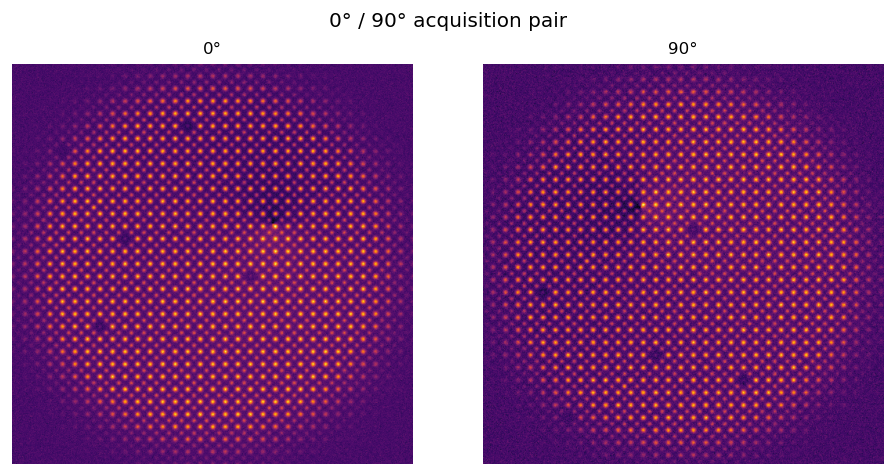

In [3]:
Show2D([img_0, img_90], title="0° / 90° acquisition pair", labels=["0°", "90°"])

## Align2D — rotation correction + translation alignment

Correct the known 90° rotation, then use phase correlation to find the residual sub-pixel translation.

In [4]:
# Correct the known 90° rotation, then align residual translation
img_90_corrected = np.rot90(img_90, k=-1)

w = Align2D(
    img_0, img_90_corrected,
    title="Crystal alignment (rotation-corrected)",
    label_a="0° (ref)", label_b="90° (corrected)",
)
w

Align2D(512×512, dx=5.2, dy=3.9, rot=0.0°)

In [5]:
dx, dy = w.offset
print(f"Rotation: {rotation_deg}°")
print(f"Translation: dx={dx:.2f}, dy={dy:.2f}")
print(f"NCC: {w.xcorr_zero:.3f} (before) → {w.ncc_aligned:.3f} (after)")

Rotation: 90°
Translation: dx=5.21, dy=3.88
NCC: 0.006 (before) → 0.755 (after)


## Inspect Widget State

In [6]:
w.summary()

Crystal alignment (rotation-corrected)
════════════════════════════════
Image:    512×512
Labels:   A='0° (ref)'  B='90° (corrected)'
Offset:   dx=5.21  dy=3.88  rotation=0.00°
Display:  gray | opacity=50% | padding=20%
NCC:      aligned=0.7547  zero=0.0059
